# HW: Apple 
### Predicción de Series Temporales
#### Carlos Sebastiani

In [53]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.arima import AutoARIMA


In [2]:
# Reading data
apple_df = pd.read_csv('../apple/aapl.csv',sep=';',decimal=',')
apple_df['fecha'] = pd.to_datetime(apple_df['fecha']) ## converting to data format
apple_df = apple_df.set_index('fecha') ##setting columns date as a index
apple_df.head()

,Trimeste,Ingresos
fecha,,
1989-12-29,Q1 1990,1493.4
1990-03-30,Q2 1990,1346.2
1990-06-29,Q3 1990,1364.8
1990-09-28,Q4 1990,1354.1
1990-12-28,Q1 1991,1675.5


In [3]:
apple_ts=apple_df.resample("q").last()
apple_ts.tail()

,Trimeste,Ingresos
fecha,,
2020-06-30,Q3 2020,59685.0
2020-09-30,Q4 2020,64698.0
2020-12-31,Q1 2021,111439.0
2021-03-31,Q2 2021,89584.0
2021-06-30,Q3 2021,81434.0


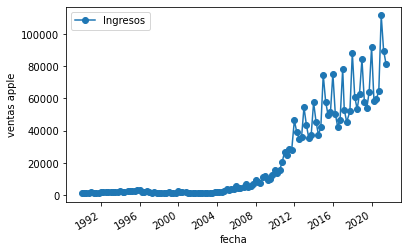

In [4]:
## Graficamos para observar como se comportan las ventas
ax = apple_df.plot(marker='o', linestyle='-')
ax.set_ylabel('ventas apple');

**Analizamos al estacionalidad**

In [5]:
## Creamos formulas para revisar si la media y la varianza son estacionarias
def split_and_summarize(dataframe,column,size,fn):
    ranges = []
    values =[]
    for i in range(0,len(dataframe),size):
        ranges.append(dataframe[i:i+size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

##Utilizamos la formula para obtener los valores de la media y la varianza
        
means = split_and_summarize(apple_df,'Ingresos',16,np.mean)
variances = split_and_summarize(apple_df,'Ingresos',16,np.var)

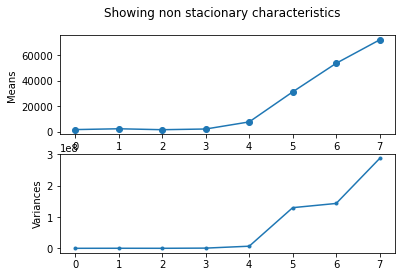

In [6]:
# Plotting means and variances

cols = ['means', 'variances']
df = pd.DataFrame([means,variances],index=cols)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Showing non stacionary characteristics')

ax1.plot(means, 'o-')
ax1.set_ylabel('Means')

ax2.plot(variances, '.-')
ax2.set_ylabel('Variances')

plt.show()

Text(0.5, 1.0, 'Comportamiento Estacional')

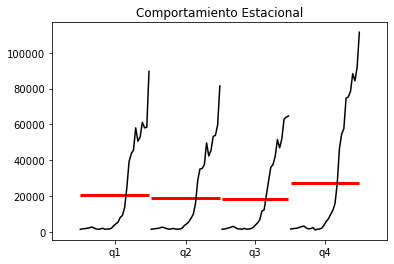

In [7]:
ax = plt.gca()
sm.graphics.tsa.quarter_plot(apple_ts['Ingresos'],ax=ax)
ax.set_title('Comportamiento Estacional')

#### Conclusiones sobre estacionariedad:
Como se puede observar los ingresos de apple no son estaciarios ni en media ni en varianza, ya que ambos cambian con el tiempo. 

En el primer gráfico se puedee observar como no solo hay una tendencia al crecimiento, sino que hay movimiento de oscilación dentro del año, siendo el 4 trimestre más importante en ventas. 

Con el segundo gráfico de media y varianza para períodos de 8Q´s se confirma quee tanto la media como la varianza ascienden con el tiempo. 



In [96]:
#Analisis de las ventas en períodos anuales
apple_yearly = apple_ts.resample('Y').sum()
apple_yearly.head()

,Ingresos
fecha,
1989-12-31,1493.4
1990-12-31,5740.6
1991-12-31,6496.0
1992-12-31,7224.2
1993-12-31,8445.6


In [9]:
#apple_yearly.head()
apple_ts.head()

,Trimeste,Ingresos
fecha,,
1989-12-31,Q1 1990,1493.4
1990-03-31,Q2 1990,1346.2
1990-06-30,Q3 1990,1364.8
1990-09-30,Q4 1990,1354.1
1990-12-31,Q1 1991,1675.5


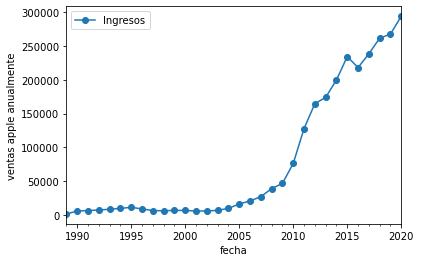

In [10]:
ax = apple_yearly[:'2020'].plot(marker='o', linestyle='-')
ax.set_ylabel('ventas apple anualmente');

In [16]:
#crecimientos anuales de los ingresos
apple_sales_growth = apple_yearly['1990':'2020'].pct_change().mul(100).dropna()
apple_sales_growth.head()

,Ingresos
fecha,
1991-12-31,13.158903
1992-12-31,11.209975
1993-12-31,16.907062
1994-12-31,13.099129
1995-12-31,19.117662


Text(0.5, 1.0, 'Crecimiento de Apple en %')

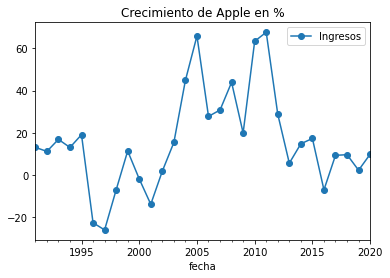

In [17]:
ax = apple_sales_growth.plot(marker='o', linestyle='-')
ax.set_title('Crecimiento de Apple en %')



## Modelo de Suavizado Exponencial
Separamos la muestra entre la parte de estimación y la parte de predicción, dejando el 80% de los datos para estimación y 20% para testeo

119 8


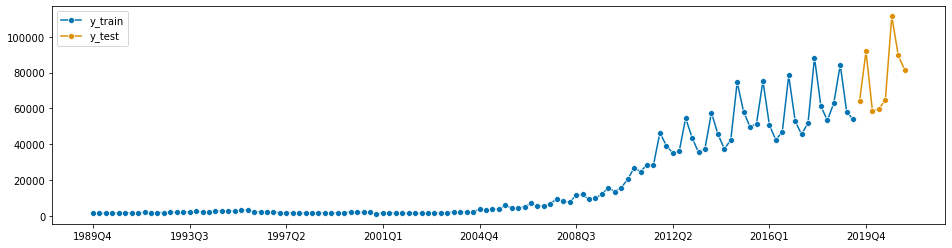

In [58]:
## Graficamos la los datos en dos partes, los que usaremos para test y los que usaremos para entrenar
y_train, y_test = temporal_train_test_split(y = apple_ts['Ingresos'].astype('float64').to_period('Q'), test_size=8)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [65]:
## vamos a forecastear el horizonte temporal de 13 Qs que son los que hemos dejado de testeo
fh = np.arange(1, 9)
apple_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)

In [66]:
apple_auto_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [67]:
print(apple_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Sat, 30 Oct 2021   AIC                           1956.050
Time:                        13:30:21   BIC                           1983.841
Sample:                    12-31-1989   HQIC                          1967.335
                         - 06-30-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal  

In [68]:
# step 5: querying predictions
apple_pred = apple_auto_model.predict(fh)
print(apple_pred)

2019Q3    58581.329864
2019Q4    85963.046083
2020Q1    59751.803939
2020Q2    53079.531957
2020Q3    58323.474571
2020Q4    85584.248858
2021Q1    59488.216501
2021Q2    52845.119874
Freq: Q-DEC, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

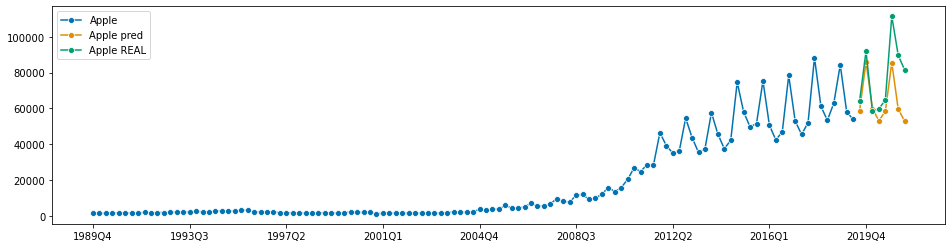

In [69]:
## plot to check the series with the predictions
plot_series(y_train, apple_pred,y_test, labels=["Apple", "Apple pred", "Apple REAL"])

In [70]:
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, apple_pred)

0.18651410968558557

In [71]:
mse = MeanSquaredError()
mse(y_test, apple_pred)

317746827.88833416

In [72]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, apple_pred)

17825.454493177283

In [95]:
apple_ts

,Ingresos
fecha,
1989-12-31,1493.4
1990-03-31,1346.2
1990-06-30,1364.8
1990-09-30,1354.1
1990-12-31,1675.5
...,...
2020-06-30,59685.0
2020-09-30,64698.0
2020-12-31,111439.0


In [94]:
## Forecasting next 6 Qs
fh = np.arange(1, 7)

# step 3: specifying the forecasting algorithm
apple_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)

y = apple_ts['Ingresos'].astype('float64').to_period('Q')

apple_auto_model.fit(y)

print(apple_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  127
Model:                       ETS(MAM)   Log Likelihood               -1052.310
Date:                Sat, 30 Oct 2021   AIC                           2124.620
Time:                        14:18:31   BIC                           2153.062
Sample:                    12-31-1989   HQIC                          2136.176
                         - 06-30-2021   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4303      0.055      7.816      0.000       0.322       0.538
smoothing_trend        0.1718      0.035      4.969      0.000       0.104       0.240
smoothing_seasonal  

In [74]:
# step 5: querying predictions
apple_pred = apple_auto_model.predict(fh)
print(apple_pred)

2021Q3     94928.198203
2021Q4    153907.757050
2022Q1    112068.412058
2022Q2    104446.064222
2022Q3    120404.571581
2022Q4    192615.716804
Freq: Q-DEC, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

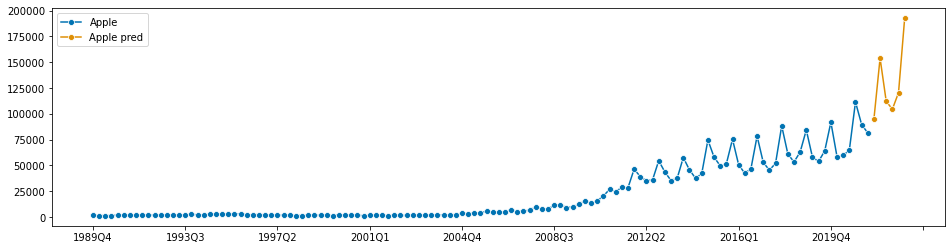

In [75]:
plot_series(y, apple_pred, labels=["Apple", "Apple pred"])

## ARIMA

In [34]:
apple_ts = apple_ts.drop('Trimeste',axis =1)

In [35]:
apple_ts_q=apple_df['Ingresos'].astype('float64').to_period('Q').sort_index()
apple_ts_q.tail()

fecha
2020Q2     59685.0
2020Q3     64698.0
2020Q4    111439.0
2021Q1     89584.0
2021Q2     81434.0
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [36]:
# Apply Log Transformer
transformer = LogTransformer()
log_apple_ts_q= transformer.fit_transform(apple_ts_q)
log_apple_ts_q.tail()

fecha
2020Q2    10.996836
2020Q3    11.077486
2020Q4    11.621233
2021Q1    11.402932
2021Q2    11.307548
Freq: Q-DEC, Name: Ingresos, dtype: float64

Text(0.5, 1.0, 'Ventas Apple: Transformación LOG')

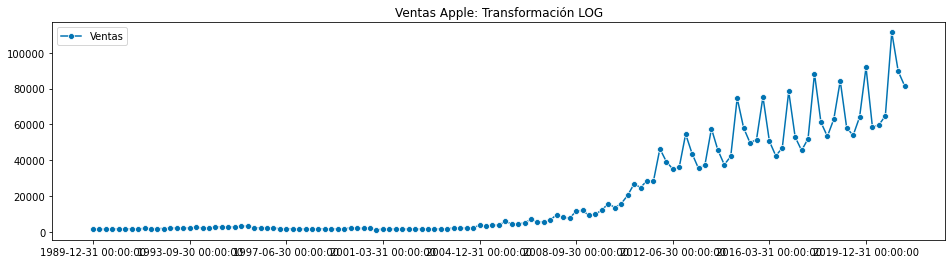

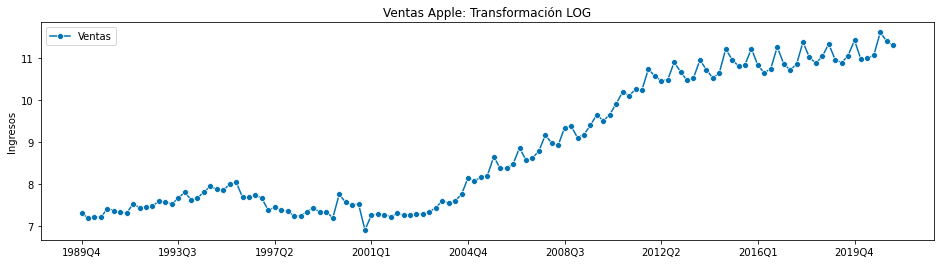

In [38]:
# Plogging original series and log data together
fig, ax = plot_series(apple_ts, labels=["Ventas"])
ax.set_title('Ventas Apple: Transformación LOG')

fig, ax = plot_series(log_apple_ts_q, labels=["Ventas"])
ax.set_title('Ventas Apple: Transformación LOG')

## Estacionalidad

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

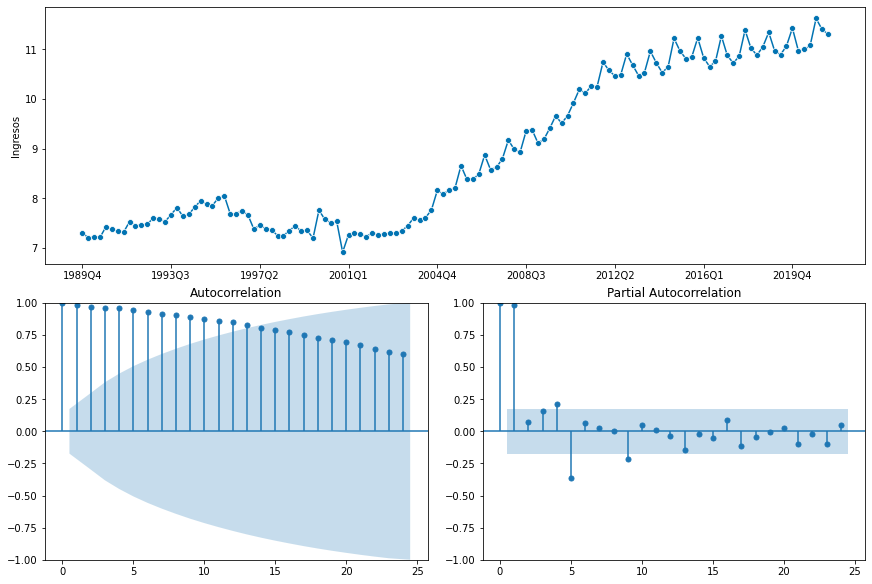

In [42]:
plot_correlations(log_apple_ts_q)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

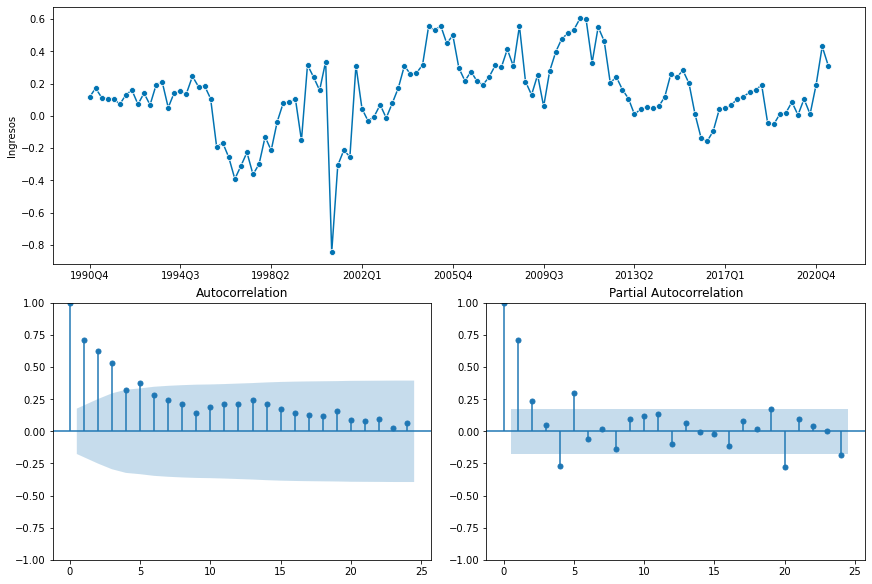

In [48]:
##Autocorrelation Function with Lags 4 
transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(log_apple_ts_q))

In [50]:
## Separamos la muestra logaritimica

log_y_train, log_y_test = temporal_train_test_split(y=log_apple_ts_q, test_size=8)

In [77]:
fh = np.arange(8)  # forecasting horizon
fh

array([0, 1, 2, 3, 4, 5, 6, 7])

In [78]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

In [79]:
#  Auto ARIMA Model Summary
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  58.362
Date:                           Sat, 30 Oct 2021   AIC                           -108.724
Time:                                   13:33:58   BIC                            -97.642
Sample:                                        0   HQIC                          -104.224
                                           - 119                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3363      0.089     -3.795      0.000      -0.510      -0.163
ar.S.L4        0.9156      0.062     14.823

In [80]:
log_y_pred = forecaster.predict(fh)
log_y_pred

/opt/anaconda3/envs/Series_Temporales/lib/python3.9/site-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


2019Q2    10.879887
2019Q3    11.005156
2019Q4    11.335688
2020Q1    11.027220
2020Q2    10.934802
2020Q3    11.039463
2020Q4    11.342092
2021Q1    11.059665
Freq: Q-DEC, dtype: float64

In [84]:
#  Auto ARIMA Forecast
# Original Time series (Invert log transformation)
apple_pred_arima=np.exp(log_y_pred)

In [83]:
mean_absolute_percentage_error(log_y_test, log_y_pred)
#mse = MeanSquaredError()
#mse(log_y_test, log_y_pred)
#rmse = MeanSquaredError(square_root=True)
#rmse(log_y_test, log_y_pred)

0.02272283084099036

In [85]:
mean_absolute_percentage_error(apple_pred_arima,y_test)

0.2509305965742026

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

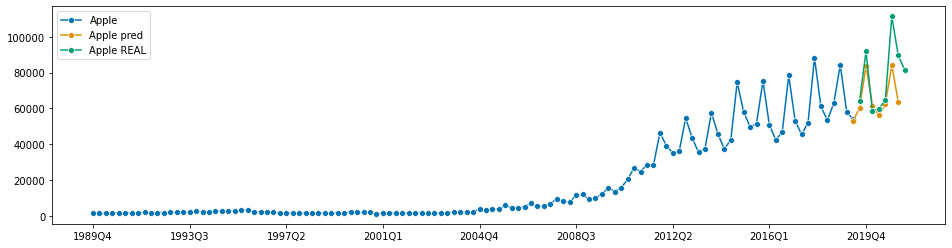

In [86]:
plot_series(y_train, apple_pred_arima,y_test, labels=["Apple", "Apple pred", "Apple REAL"])

In [88]:
log_y_pred = forecaster.predict(fh)
log_y_pred

/opt/anaconda3/envs/Series_Temporales/lib/python3.9/site-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


2019Q2    10.879887
2019Q3    11.005156
2019Q4    11.335688
2020Q1    11.027220
2020Q2    10.934802
2020Q3    11.039463
2020Q4    11.342092
2021Q1    11.059665
Freq: Q-DEC, dtype: float64

In [89]:
fh = np.arange(6) + 1  # forecasting horizon
fh

array([1, 2, 3, 4, 5, 6])

In [90]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_apple_ts_q)

AutoARIMA(sp=4, suppress_warnings=True)

In [91]:
#  Auto ARIMA Model Summary
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  127
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 4)   Log Likelihood                  65.973
Date:                           Sat, 30 Oct 2021   AIC                           -117.945
Time:                                   13:52:56   BIC                            -98.091
Sample:                                        0   HQIC                          -109.879
                                           - 127                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0879      0.214     -5.088      0.000      -1.507      -0.669
ar.L2         -0.3711      0.096     -3.868

In [92]:
#  Auto ARIMA Forecast
log_y_pred = forecaster.predict(fh)
log_y_pred

2021Q3    11.440423
2021Q4    11.869057
2022Q1    11.624029
2022Q2    11.542784
2022Q3    11.657231
2022Q4    12.057065
Freq: Q-DEC, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

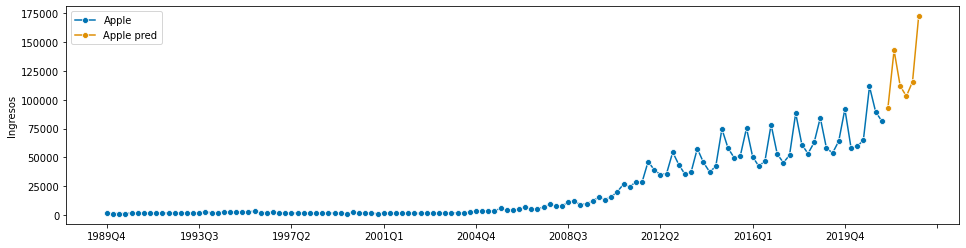

In [93]:
plot_series(apple_ts_q, np.exp(log_y_pred), labels=["Apple", "Apple pred"])